## Toric code example

In the `getting-started.ipynb` notebook, we show how to use pymatching to decode stim circuits. This is perhaps the most typical use case for pymatching, as stim can be used to simulate a very broad class of quantum error correction codes and circuits (including those used in this notebook).

However, some other input formats can also be useful for configuring and using pymatching, without the need to use stim. In this notebook, we'll show how parity check matrices can be used to simulate and decode some simple QEC circuits, using the toric code as an example.

We will use PyMatching to estimate the threshold of the toric code 
under an independent noise model with perfect syndrome measurements.
The decoding problem for the toric code is identical for $X$-type and $Z$-type 
errors, so we will only simulate decoding $Z$-type errors using $X$-type stabilisers in this example.

First, we will construct a check matrix $H_X$ corresponding to the $X$-type stabilisers.
Each element $H_X[i,j]$ will be 1 if the $i$th $X$ stabiliser acts non-trivially on 
the $j$th qubit, and is 0 otherwise.


We will construct $H_X$ by taking the [hypergraph product](https://arxiv.org/abs/0903.0566) of two repetition codes.
The hypergraph product code construction $HGP(H_1,H_2)$ takes as input the parity check 
matrices of two linear codes $C_1:=\ker H_1$ and $C_2:= \ker H_2$. The code $HGP(H_1,H_2)$ 
is a CSS code with the check matrix for the $X$ stabilisers given by

$$H_X=[H_1\otimes I_{n_2},I_{r_1}\otimes H_2^T]$$

and with the check matrix for the $Z$ stabilisers given by 

$$H_Z=[I_{n_1}\otimes H_2,H_1^T\otimes I_{r_2}]$$

where $H_1$ has dimensions $r_1\times n_1$, $H_2$ has dimensions $r_2\times n_2$ and $I_l$ denotes the $l\times l$ identity matrix.

Since we only need the $X$ stabilisers of the toric code with lattice size L, we only need to construct $H_X$, using the check matrix of a repetition code with length L for both $H_1$ and $H_2$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag


def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1) % n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def toric_code_x_stabilisers(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with 
    lattice size L, constructed as the hypergraph product of 
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
        [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
        dtype=np.uint8
    )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

From the [K&uuml;nneth theorem](https://en.wikipedia.org/wiki/K%C3%BCnneth_theorem), the $X$ logical operators of the toric code are given by

$$L_X=\left(
  \begin{array}{cc}
  \mathcal{H}^1\otimes \mathcal{H}^0 & 0 \\
  0 & \mathcal{H}^0\otimes \mathcal{H}^1
\end{array} \right)$$

where $\mathcal{H}^0$ and $\mathcal{H}^1$ are the zeroth and first cohomology groups of the length-one chain complex that has the repetition code parity check matrix as its boundary operator. We can construct this matrix with the following function:

In [2]:
def toric_code_x_logicals(L):
    """
    Sparse binary matrix with each row corresponding to an X logical operator 
    of a toric code with lattice size L. Constructed from the 
    homology groups of the repetition codes using the Kunneth 
    theorem.
    """
    H1 = csc_matrix(([1], ([0], [0])), shape=(1, L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    x_logicals = block_diag([kron(H1, H0), kron(H0, H1)])
    x_logicals.data = x_logicals.data % 2
    x_logicals.eliminate_zeros()
    return csc_matrix(x_logicals)

Now that we have the $X$ check matrix and $X$ logicals of the toric code, we can use PyMatching to simulate its performance using the minimum-weight perfect matching decoder and an error model of our choice.

To do so, we first import the Matching class from PyMatching, and use it to construct a Matching object from the check matrix of the stabilisers:
```
from pymatching import Matching
matching=Matching(H)
```
Constructing the Matching object, while efficient, is often slower than the decoding step itself. As a result, it's best to construct the Matching object only at the beginning of the experiment, and not before every use of the decoder, in order to obtain the best performance.

We also choose a number of trials, `num_shots`.  For each trial, we simulate a $Z$ error under an independent noise model, in which each qubit independently suffers a $Z$ error with probability $p$:
```
noise = np.random.binomial(1, p, H.shape[1])
```
Here, `noise` is a binary vector and `noise[i]` is 1 if qubit $i$ suffers a $Z$ error, and 0 otherwise.

The syndrome of the $X$ stabilisers is then calculated from the dot product (modulo 2) with the $X$ check matrix $H$:
```
syndrome = H@noise % 2
```

We can now use PyMatching to infer the most probable individual error given the syndrome:
```
prediction = matching.decode(syndrome)
```

We use this to predict which logical X operators have been flipped:

```
predicted_logicals_flipped = logicals@prediction % 2
```

The actual logicals that were flipped are:

```
actual_logicals_flipped = logicals@noise % 2
```

Our decoder was successful if `actual_logical_observables` equals `predicted_logical_observables`.

Taken together, we obtain the following function `num_decoding_failures` that returns the number of logical errors after `num_shots` Monte Carlo trials, simulating an independent error model with error probability `p`, with the $X$ stabiliser check matrix `H` and $X$ logical matrix `logicals`:

In [3]:
from pymatching import Matching


def num_decoding_failures_via_physical_frame_changes(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability))
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < error_probability).astype(np.uint8)
        syndrome = H@noise % 2
        prediction = matching.decode(syndrome)
        predicted_logicals_flipped = logicals@prediction % 2
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

We can speed this up slightly by telling PyMatching about the logical operators matrix when we create the `pymatching.Matching` object, 
using the `faults_matrix` argument. 
By doing this, `pymatching.Matching.decode` directly predicts which logicals have been flipped. This is a bit faster, as it allows the decoder to make some more optimisations.

In [4]:
def num_decoding_failures(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability), faults_matrix=logicals)
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < error_probability).astype(np.uint8)
        syndrome = H@noise % 2
        predicted_logicals_flipped = matching.decode(syndrome)
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

We can optimise the code a bit further by vectorising over the shots, using the `Matching.decode_batch` method. This method takes in a binary numpy array with dimensions (num_shots, syndrome_length), where syndrome_length should be large enough to include all detector nodes, and be no larger than the number of nodes (including boundary nodes). By vectorising, the iteration over shots is done in C++ rather than Python, which can be significantly faster when the decoding problem itself is easy.

In [5]:
def num_decoding_failures_vectorised(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability), faults_matrix=logicals)
    noise = (np.random.random((num_shots, H.shape[1])) < error_probability).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

Using this function, we can now estimate the threshold of the toric code by varying the error rate $p$, for a range of lattice sizes $L$:

In [6]:
%%time

num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.01, 0.2, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...
CPU times: user 2.69 s, sys: 7.43 ms, total: 2.7 s
Wall time: 2.83 s


Finally, let's plot the results! We expect to see a threshold of around 10.3%, although a precise estimate requires using more trials, larger lattice sizes and scanning more values of $p$:

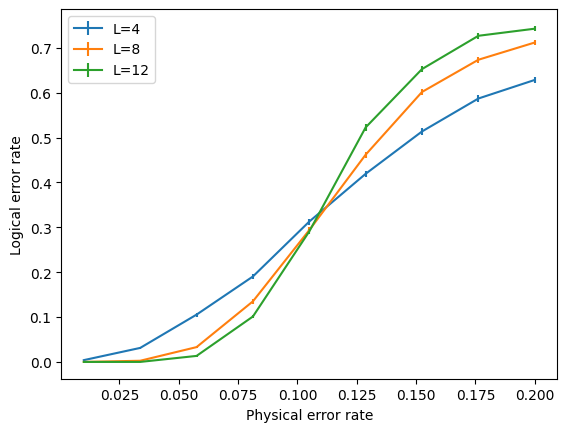

In [7]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

## Noisy syndromes

In the presence of measurement errors, each syndrome measurement is repeated $O(L)$ times, and decoding instead takes place over a 3D matching graph with an additional time dimension (see Section IV B of [this paper](https://arxiv.org/abs/quant-ph/0110143)). The time dimension can be added to the matching graph by specifying the number of repetitions when constructing the matching object:
```
matching = Matching(H, repetitions=T)
```
where here $T$ is the number of repetitions. For decoding, the difference syndrome should be supplied as an $r\times T$ binary numpy matrix, where $r$ is the number of checks (rows in $H$). The difference syndrome in time step $t$ is the difference (modulo 2) between the syndrome measurement in time step $t$ and $t-1$, and ensures that any single measurement error results in two syndrome defects (at the endpoints of a timelike edge in the matching graph). The last round of syndrome measurements should be free of measurement errors to ensure that the overall syndrome has even parity: when qubits are measured individually at the end of a computation then the final round of syndrome measurement is indeed error-free (stabilisers can be determined exactly in post-processing), however the [overlapping recovery method](https://arxiv.org/abs/quant-ph/0110143) should be implemented when decoding must be completed before all qubits are measured.

The following example demonstrates decoding in the presence of measurement errors using a phenomenological error model. In this error model, in each round of measurements each qubit suffers an error with probability $p$, and each syndrome is measured incorrectly with probability $q$.

In [8]:
def num_decoding_failures_noisy_syndromes(H, logicals, p, q, num_shots, repetitions):
    matching = Matching(H, weights=np.log((1-p)/p),
                        repetitions=repetitions, timelike_weights=np.log((1-q)/q), faults_matrix=logicals)
    num_stabilisers, num_qubits = H.shape
    num_errors = 0
    for i in range(num_shots):
        noise_new = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)
        noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
        noise_total = noise_cumulative[:, -1]
        syndrome = H@noise_cumulative % 2
        syndrome_error = (np.random.rand(num_stabilisers, repetitions) < q).astype(np.uint8)
        syndrome_error[:, -1] = 0  # Perfect measurements in last round to ensure even parity
        noisy_syndrome = (syndrome + syndrome_error) % 2
        # Convert to difference syndrome
        noisy_syndrome[:, 1:] = (noisy_syndrome[:, 1:] - noisy_syndrome[:, 0:-1]) % 2
        predicted_logicals_flipped = matching.decode(noisy_syndrome)
        actual_logicals_flipped = noise_total@logicals.T % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

We'll now simulate the performance of the decoder for a range of lattice sizes $L$ and physical error rate $p$ (taking $q=p$) and estimate the threshold:

In [9]:
%%time

num_shots = 3000
Ls = range(8,13,2)
ps = np.linspace(0.02, 0.04, 7)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_noisy_syndromes(Hx, logX, p, p, num_shots, L)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=8...
Simulating L=10...
Simulating L=12...
CPU times: user 33.8 s, sys: 31.3 ms, total: 33.8 s
Wall time: 34.8 s


Plotting the results, we find a threshold of around 3%, consistent with the threshold of 2.9% found in [this paper](https://arxiv.org/abs/quant-ph/0207088):

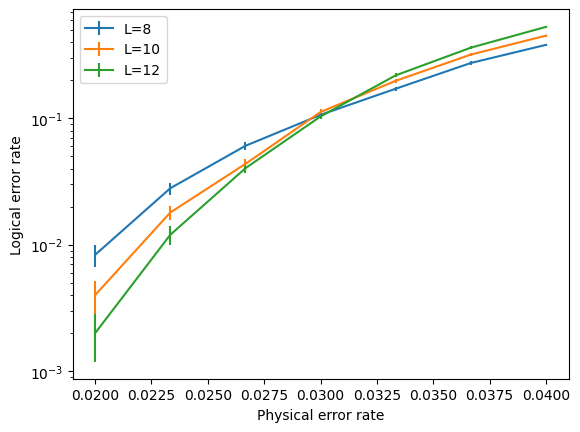

In [10]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

## Simulating circuit-level noise

PyMatching can be combined with [Stim](https://github.com/quantumlib/Stim) to decode in the presence of more realistic noise models, where errors can occur during any gate in the syndrome extraction circuit. To do this, you construct a Stim circuit for the noisy quantum error correction circuit you want to simulate (e.g. a toric code memory experiment). Stim can sample syndromes (detector measurement outcomes) from the circuit and also provides a DetectorErrorModel (essentially a generalisation of a matching graph) which PyMatching uses to construct the `Matching` object for decoding the syndrome.

Note that the [sinter](https://github.com/quantumlib/Stim/tree/main/glue/sample) package combines Stim and PyMatching and uses parallelisation over shots to run error correction simulations more efficiently. It also includes other tools (such as for plotting and analysing data). However, here we will use Stim and PyMatching directly to demonstrate how the APIs can be used.

We will use the surface code here (instead of the toric code), since surface code example circuits are already included with Stim. In general you should write your own circuits tailored to the research problem you are trying to solve, however the example circuits are useful for getting started. Here we will sample shots from surface code circuits over a range of lattice sizes and circuit-level error rates:


In [11]:
%%time

import stim

num_shots = 20000
Ls = range(5,14,4)
ps = np.linspace(0.004, 0.01, 7)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    log_errors = []
    for p in ps:
        circuit = stim.Circuit.generated("surface_code:rotated_memory_x", 
                                        distance=L, 
                                        rounds=L, 
                                        after_clifford_depolarization=p,
                                        before_round_data_depolarization=p,
                                        after_reset_flip_probability=p,
                                        before_measure_flip_probability=p)
        model = circuit.detector_error_model(decompose_errors=True)
        matching = Matching.from_detector_error_model(model)
        sampler = circuit.compile_detector_sampler()
        syndrome, actual_observables = sampler.sample(shots=num_shots, separate_observables=True)
        predicted_observables = matching.decode_batch(syndrome)
        num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=5...
Simulating L=9...
Simulating L=13...
CPU times: user 48.2 s, sys: 228 ms, total: 48.4 s
Wall time: 49.6 s


Now let's plot the results:

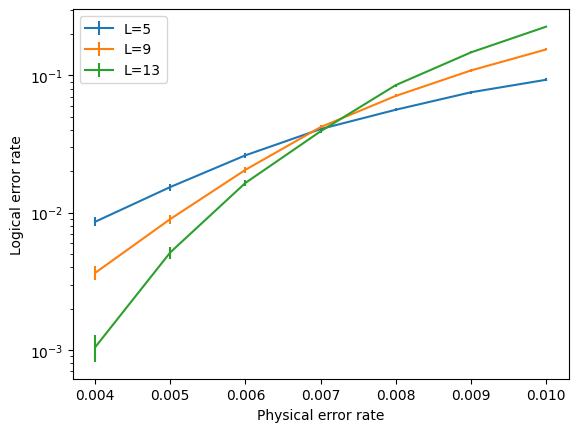

In [12]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

We see a threshold of around 0.7% for circuit-level depolarising noise in the surface code. For more examples of how to use Stim with PyMatching (e.g. to estimate the required size of a surface code circuit to achieve a given error rate), see the [Stim documentation](https://github.com/quantumlib/Stim/tree/main/doc), including the getting started notebook.